In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim



from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: 

Saving cancer.zip to cancer.zip


In [ ]:
!unzip cancer.zip -d cancer/   

Archive:  cancer.zip
  inflating: cancer/test/normal/10F16_CRC-Prim-HE-09_013.tif_Row_301_Col_451.jpg  
  inflating: cancer/test/normal/10F22_CRC-Prim-HE-05_001.tif_Row_301_Col_751.jpg  
  inflating: cancer/test/normal/10F32_CRC-Prim-HE-03_012.tif_Row_1_Col_301.jpg  
  inflating: cancer/test/normal/10F53_CRC-Prim-HE-07_001.tif_Row_451_Col_2551.jpg  
  inflating: cancer/test/normal/10F59_CRC-Prim-HE-06_004.tif_Row_1051_Col_1351.jpg  
  inflating: cancer/test/normal/10F5B_CRC-Prim-HE-08_013.tif_Row_301_Col_151.jpg  
  inflating: cancer/test/normal/10F6C_CRC-Prim-HE-05_032.tif_Row_751_Col_2251.jpg  
  inflating: cancer/test/normal/10F74_CRC-Prim-HE-08_021.tif_Row_1_Col_1351.jpg  
  inflating: cancer/test/normal/10F78_CRC-Prim-HE-04.tif_Row_1801_Col_1.jpg  
  inflating: cancer/test/normal/10F7D_CRC-Prim-HE-03_012.tif_Row_3001_Col_2251.jpg  
  inflating: cancer/test/normal/10F84_CRC-Prim-HE-03_025.tif_Row_151_Col_451.jpg  
  inflating: cancer/test/normal/10F88_CRC-Prim-HE-07_014.tif_Row_601

In [ ]:
data_path = 'cancer/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

1000


In [ ]:
test_path = 'cancer/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

250


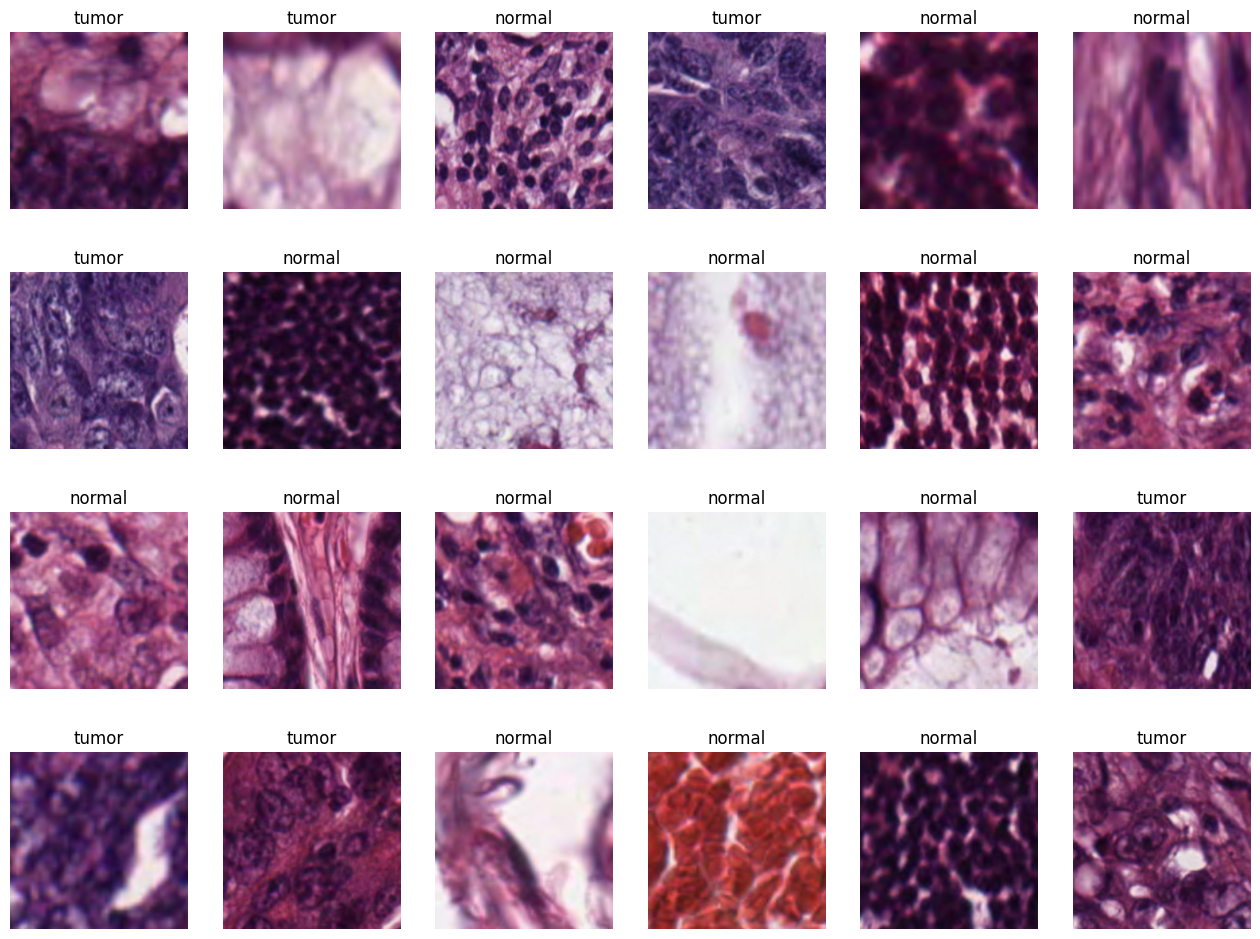

In [ ]:
samples, labels = next(iter(train_loader))
classes = {0: 'normal', 1: 'tumor'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
class CancerCNN(nn.Module):    
    def __init__(self):
        super(CancerCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        self.fc1 = nn.Linear(in_features=193600, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001;
model = CancerCNN();
model.to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

CancerCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=193600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=1, bias=True)
)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=50, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('cancer/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [ ]:
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 15.7268 Acc: 0.6810

Epoch 1/49
----------
Loss: 3.2754 Acc: 0.7560

Epoch 2/49
----------
Loss: 1.5608 Acc: 0.7560

Epoch 3/49
----------
Loss: 0.5991 Acc: 0.8090

Epoch 4/49
----------
Loss: 0.5605 Acc: 0.8090

Epoch 5/49
----------
Loss: 0.5076 Acc: 0.8470

Epoch 6/49
----------
Loss: 0.6839 Acc: 0.7790

Epoch 7/49
----------
Loss: 0.4956 Acc: 0.8630

Epoch 8/49
----------
Loss: 0.5757 Acc: 0.8340

Epoch 9/49
----------
Loss: 0.4666 Acc: 0.8450

Epoch 10/49
----------
Loss: 0.4769 Acc: 0.8520

Epoch 11/49
----------
Loss: 0.4502 Acc: 0.8520

Epoch 12/49
----------
Loss: 0.4865 Acc: 0.8280

Epoch 13/49
----------
Loss: 0.4422 Acc: 0.8450

Epoch 14/49
----------
Loss: 0.3789 Acc: 0.8640

Epoch 15/49
----------
Loss: 0.3779 Acc: 0.8600

Epoch 16/49
----------
Loss: 0.3583 Acc: 0.8540

Epoch 17/49
----------
Loss: 0.4845 Acc: 0.8370

Epoch 18/49
----------
Loss: 0.4888 Acc: 0.8440

Epoch 19/49
----------
Loss: 0.9517 Acc: 0.8170

Epoch 20/49
----------
Loss: 5.6235 Acc: 0.7600

Ep

In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('cancer/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            preds = torch.sigmoid(outputs).squeeze()       
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history



In [ ]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['cancer/00.pth', 'cancer/01.pth', 'cancer/02.pth', 'cancer/03.pth', 'cancer/04.pth', 'cancer/05.pth', 'cancer/06.pth', 'cancer/07.pth', 'cancer/08.pth', 'cancer/09.pth', 'cancer/10.pth', 'cancer/11.pth', 'cancer/12.pth', 'cancer/13.pth', 'cancer/14.pth', 'cancer/15.pth', 'cancer/16.pth', 'cancer/17.pth', 'cancer/18.pth', 'cancer/19.pth', 'cancer/20.pth', 'cancer/21.pth', 'cancer/22.pth', 'cancer/23.pth', 'cancer/24.pth', 'cancer/25.pth', 'cancer/26.pth', 'cancer/27.pth', 'cancer/28.pth', 'cancer/29.pth', 'cancer/30.pth', 'cancer/31.pth', 'cancer/32.pth', 'cancer/33.pth', 'cancer/34.pth', 'cancer/35.pth', 'cancer/36.pth', 'cancer/37.pth', 'cancer/38.pth', 'cancer/39.pth', 'cancer/40.pth', 'cancer/41.pth', 'cancer/42.pth', 'cancer/43.pth', 'cancer/44.pth', 'cancer/45.pth', 'cancer/46.pth', 'cancer/47.pth', 'cancer/48.pth', 'cancer/49.pth']
Loading model cancer/00.pth
Acc: 0.7480

Loading model cancer/01.pth
Acc: 0.8880

Loading model cancer/02.pth
Acc: 0.9160

Loading model 

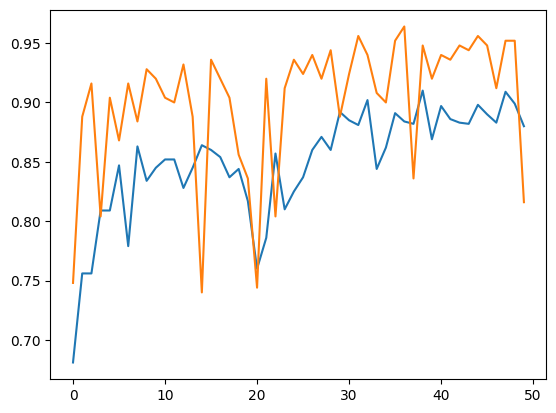

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

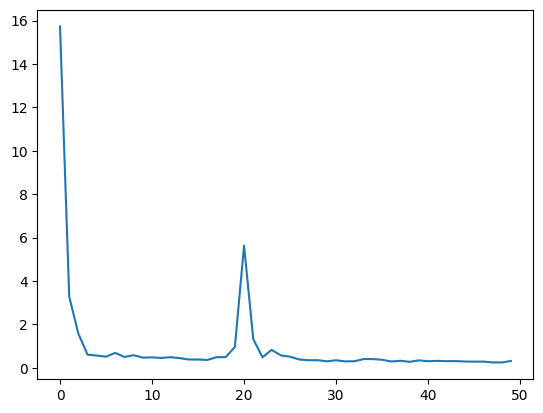

In [ ]:
plt.plot(train_loss_hist)
plt.show()